In [ ]:
# pip install cvxpy openpyxl ecos scs

In [1]:
import re, numpy as np, pandas as pd, cvxpy as cp
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore")

### Liabilities

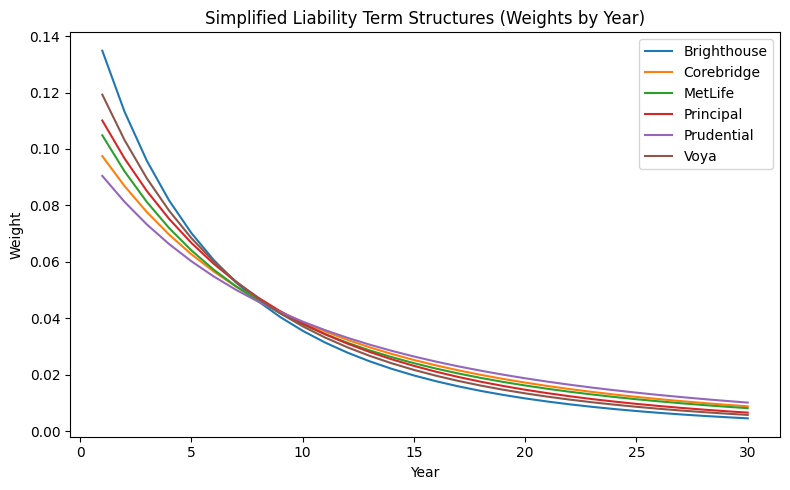

'Liability_Profiles.xlsx'

In [2]:
T = 30
years = np.arange(1, T + 1)

# --- Bucket duration presets (years) ---
# Keep these simple and consistent; you can tweak per company if desired.
bucket_durations_default = {
    "Short": 4.0,
    "Medium": 8.0,
    "Long": 20.0,
}

# --- Company-specific mixes (weights must sum to 1) ---
# These are intentionally simple and aligned with each company's product mix:
# - More "retirement / VA hedging" -> more Medium, some Short
# - More "ULSG / payout annuities"  -> more Long
# - More "group benefits / stable value" -> more Short
company_bucket_weights = {
    "Brighthouse": {"Short": 0.30, "Medium": 0.55, "Long": 0.15},
    "Corebridge":  {"Short": 0.15, "Medium": 0.55, "Long": 0.30},
    "MetLife":     {"Short": 0.25, "Medium": 0.50, "Long": 0.25},
    "Principal":   {"Short": 0.20, "Medium": 0.60, "Long": 0.20},
    "Prudential":  {"Short": 0.15, "Medium": 0.45, "Long": 0.40},
    "Voya":        {"Short": 0.30, "Medium": 0.55, "Long": 0.15},
}

# Optionally tweak bucket durations per company (keep it very minor/simple)
company_bucket_durations = {
    "Brighthouse": {"Short": 3.0, "Medium": 7.0, "Long": 15.0},
    "Corebridge":  {"Short": 4.0, "Medium": 8.0, "Long": 20.0},
    "MetLife":     {"Short": 4.0, "Medium": 8.0, "Long": 20.0},
    "Principal":   {"Short": 4.0, "Medium": 8.0, "Long": 18.0},
    "Prudential":  {"Short": 4.0, "Medium": 8.0, "Long": 20.0},
    "Voya":        {"Short": 4.0, "Medium": 8.0, "Long": 18.0},
}

def make_liability_curve(weights, durations, years):
    """
    Exponential-decay blend:
        CF_t ∝ sum_b [ w_b * exp(-t / D_b) ]
    Then normalize so weights sum to 1 across t=1..T.
    """
    curve = np.zeros_like(years, dtype=float)
    for b, w in weights.items():
        D = durations[b]
        curve += w * np.exp(-years / D)
    curve /= curve.sum()
    return curve

# Build curves and summary metrics
records = []
summary_rows = []
curves = {}

for company, wts in company_bucket_weights.items():
    durs = company_bucket_durations.get(company, bucket_durations_default)
    curve = make_liability_curve(wts, durs, years)
    curves[company] = curve

    # Simple "Macaulay-like" stats on the discrete weights (no discount curve applied here)
    duration_years = float(np.sum(curve * years))
    convexity = float(np.sum(curve * (years ** 2)))  # rough proxy (unscaled)

    # Liquidity metrics (share of total CF in first 1y / 5y)
    liq_1y = float(curve[0])  # year 1 weight
    liq_5y = float(np.sum(curve[:5]))

    # Save per-year records
    for t, wt in zip(years, curve):
        records.append({"Company": company, "Year": t, "Liability_Weight": wt})

    summary_rows.append({
        "Company": company,
        "Avg_Duration_yrs": duration_years,
        "Convexity_proxy": convexity,
        "Share_1Y": liq_1y,
        "Share_5Y": liq_5y,
        "Short_wt": wts["Short"],
        "Medium_wt": wts["Medium"],
        "Long_wt": wts["Long"],
        "Short_D": durs["Short"],
        "Medium_D": durs["Medium"],
        "Long_D": durs["Long"],
    })

df_curves = pd.DataFrame(records)
df_summary = pd.DataFrame(summary_rows).set_index("Company")

# Plot all six curves on one chart (each line is the per-year weight)
plt.figure(figsize=(8, 5))
for company, curve in curves.items():
    plt.plot(years, curve, label=company)
plt.title("Simplified Liability Term Structures (Weights by Year)")
plt.xlabel("Year")
plt.ylabel("Weight")
plt.legend()
plt.tight_layout()
plt.show()

# Build an Excel workbook with:
# - Assumptions sheet (bucket weights & durations)
# - LiabilityCurves sheet (per company, per year weights)
# - Summary sheet (duration, convexity proxy, liquidity shares)
assumptions_rows = []
for company in company_bucket_weights:
    row = {"Company": company}
    row.update({f"BucketWeight_{k}": v for k, v in company_bucket_weights[company].items()})
    row.update({f"BucketDur_{k}": v for k, v in company_bucket_durations[company].items()})
    assumptions_rows.append(row)
df_assumptions = pd.DataFrame(assumptions_rows).set_index("Company")

excel_path = "Liability_Profiles.xlsx"
with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
    df_assumptions.to_excel(writer, sheet_name="Assumptions")
    df_curves.pivot(index="Year", columns="Company", values="Liability_Weight").to_excel(writer, sheet_name="LiabilityCurves")
    df_summary.to_excel(writer, sheet_name="Summary")

excel_path

In [ ]:
EXCEL_PATH = "final_inputs.xlsx"
SHEET_NAME = 0
RISK_FREE = 0.04
N_FRONTIER_POINTS = 200
# DUR_TARGET = 6.0
# DUR_TOL = 1.0
LIQUID_MIN = None
W_MIN_DEFAULT = 0.00
W_MAX_DEFAULT = 0.10
LIABILITY_BOOK_PATH = "Liability_Profiles.xlsx"
LIABILITY_COMPANY = None
KRD_TOL = 0.30
SURPLUS_LAMBDA  = 8.0     # risk aversion on variance term (sweep to trace a frontier)
CAP_PENALTY_PHI  = 0.1    # φ in -φ*(cap_charge' w). Set >0 to penalize RBC use in objective
USE_KRD_MATCH    = False    # turn KRD (bucket match) on/off
KEY_BUCKETS = {"KR1": (0,7), "KR10": (7,12), "KR20": (12,40)}
# === Simulation knobs (forecast error + covariance robustness) ===
MU_NOISE_SCALE_MKT = 0.04   # common "market" shock share of typical asset vol (forecast error, not raw vol)
MU_NOISE_SCALE_ID  = 0.05   # idiosyncratic share
SIGMA_RHO_JITTER   = 0.01   # correlation jitter magnitude (0..~0.1 is mild)
SIGMA_VOL_JITTER   = 0.02   # per-asset vol jitter
SIGMA_SHRINK_ALPHA = 0.4   # shrink Sigma_sim back to base Sigma for conditioning

### Brighthouse

In [3]:
def nearest_psd(A, eps=1e-10):
    B = 0.5 * (A + A.T)
    vals, vecs = np.linalg.eigh(B)
    vals_clipped = np.maximum(vals, eps)
    return vecs @ np.diag(vals_clipped) @ vecs.T

def rating_to_numeric_fixed(rating):
    """Returns rating score only for fixed income assets, None for others"""
    scale = {
        "AAA": 1, "AA+": 2, "AA": 3, "AA-": 4,
        "A+": 5, "A": 6, "A-": 7,
        "BBB+": 8, "BBB": 9, "BBB-": 10,
        "BB+": 11, "BB": 12, "BB-": 13,
        "B+": 14, "B": 15, "B-": 16,
        "CCC": 17, "CC": 18, "C": 19
    }
    rating_str = str(rating).strip()
    if rating_str in scale:
        return scale[rating_str]
    else:
        return None  # No rating = not fixed income

def load_inputs(path, sheet=0):
    df = pd.read_excel(path, sheet_name=sheet).dropna(how="all")
    assets = df.iloc[:, 0].astype(str).values
    ratings = df.iloc[:, 1].astype(str).values
    mu = df.iloc[:, 2].astype(float).values
    cap_charge = df.iloc[:, 3].astype(float).values
    sigma_ref = df.iloc[:, 4].astype(float).values
    duration = df.iloc[:, 5].astype(float).fillna(0.0).values
    brighthouse_alloc = df.iloc[:, 6].astype(float).values
    corebridge_alloc = df.iloc[:, 7].astype(float).values
    metlife_alloc = df.iloc[:, 8].astype(float).values
    principal_alloc = df.iloc[:, 9].astype(float).values
    prudential_alloc = df.iloc[:, 10].astype(float).values
    voya_alloc = df.iloc[:, 11].astype(float).values
    n = len(assets)
    cov = df.iloc[:, 12:12+n].astype(float).values
    if cov.shape != (n, n):
        raise ValueError(f"Covariance must be {n}x{n}, got {cov.shape}")
    S = nearest_psd(0.5 * (cov + cov.T))
    
    # Package company allocations into a dictionary
    company_allocations = {
        'Brighthouse': brighthouse_alloc,
        'Corebridge': corebridge_alloc,
        'MetLife': metlife_alloc,
        'Principal': principal_alloc,
        'Prudential': prudential_alloc,
        'Voya': voya_alloc
    }
    
    return assets, ratings, mu, cap_charge, sigma_ref, duration, S, company_allocations

def load_liability_profiles(path="Liability_Profiles.xlsx"):
    """Load liability duration profiles for all companies"""
    df_summary = pd.read_excel(path, sheet_name="Summary", index_col=0)
    return df_summary

def add_liability_duration_constraint(constraints, w, duration, company_liability_duration):
    """Add asset-liability duration mismatch constraint (±1 year)"""
    portfolio_duration = duration @ w
    liability_duration = company_liability_duration
    
    # Asset-liability mismatch should not exceed ±1 year
    constraints += [portfolio_duration >= liability_duration - 1.0]
    constraints += [portfolio_duration <= liability_duration + 1.0]
    
    return constraints

def solve_surplus_qp(mu, S, duration, cap_charge, wmin, wmax,
                     assets, ratings, rating_scores,
                     company_liability_duration,
                     krd_targets=None, B=None, krd_names=None, krd_tol=0.10,
                     surplus_lambda=SURPLUS_LAMBDA, cap_penalty_phi=CAP_PENALTY_PHI):
    """
    Maximize: mu'w - λ w'Sw - φ (cap_charge'w)
    Subject to: weights, duration band, credit-quality mix, asset class caps, optional KRD bucket match.
    """
    n = len(mu)
    w = cp.Variable(n)

    # Objective: surplus-like quadratic utility with capital penalty
    objective = cp.Maximize(mu @ w - surplus_lambda * cp.quad_form(w, S) - cap_penalty_phi * (cap_charge @ w))

    constraints = [
        cp.sum(w) == 1,
        w >= wmin,
        w <= wmax,
        duration @ w >= company_liability_duration - 1.0,
        duration @ w <= company_liability_duration + 1.0
    ]

    # Credit-quality: average score <= A+ (5)
    has_rating = np.array([s is not None for s in rating_scores])
    if has_rating.any():
        rated_w = w[has_rating]
        rated_scores = np.array([s for s in rating_scores if s is not None])
        tot = cp.sum(rated_w)
        constraints += [rated_scores @ rated_w <= 5 * tot]

    rating_map = dict(zip(assets, ratings))
    is_bbb = np.array([rating_map[a] == "BBB" for a in assets])
    is_below_ig = np.array([rating_map[a] in {"BB", "BB-", "B+", "B", "B-", "CCC"} for a in assets])

    constraints += [
        cp.sum(w[is_bbb]) <= 0.15,
        cp.sum(w[is_below_ig]) <= 0.05
    ]

    is_equity = np.array(["Private Equity" in a for a in assets])
    is_hy_loans = np.array(["Leveraged Loans" in a for a in assets])
    is_emd_ig = np.array(["ex-US" in a for a in assets])
    is_real_estate = np.array(["Real Estate" in a for a in assets])
    is_cml = np.array(["Residential Mortgage Whole Loans" in a or "Commercial Mortgage Whole Loans" in a for a in assets])
    is_direct_lending = np.array(["Direct Lending" in a for a in assets])
    is_alts = np.array(["Alternatives" in a or "Special Situation" in a for a in assets])
    is_strategic = is_equity | is_hy_loans | is_emd_ig | is_real_estate | is_cml | is_direct_lending | is_alts

    constraints += [
        cp.sum(w[is_equity]) <= 0.05,
        cp.sum(w[is_hy_loans]) <= 0.05,
        cp.sum(w[is_emd_ig]) <= 0.10,
        cp.sum(w[is_real_estate]) <= 0.05,
        cp.sum(w[is_cml]) <= 0.20,
        cp.sum(w[is_direct_lending]) <= 0.20,
        cp.sum(w[is_alts]) <= 0.05,
        cp.sum(w[is_strategic]) <= 0.35
    ]

    # Optional: coarse KRD bucket match
    if (krd_targets is not None) and (B is not None):
        port_bucket = B.T @ w
        target_vec = np.array([krd_targets[k] for k in krd_names])
        eps = 0.01
        constraints += [port_bucket >= (1 - krd_tol) * target_vec - eps]
        constraints += [port_bucket <= (1 + krd_tol) * target_vec + eps]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.ECOS, verbose=False)

    if prob.status in ("optimal", "optimal_inaccurate"):
        w_opt = w.value
        return w_opt, float(w_opt @ S @ w_opt), float(mu @ w_opt)
    return None


def liability_bucket_targets(liability_path, company, key_buckets=KEY_BUCKETS):
    """Read Liability_Profiles.xlsx -> 'LiabilityCurves' sheet and compute target weights per key bucket."""
    df = pd.read_excel(liability_path, sheet_name="LiabilityCurves").set_index("Year")
    if company not in df.columns:
        raise ValueError(f"Company '{company}' not in 'LiabilityCurves' sheet.")
    curve = df[company].values
    T = len(curve)
    def clip(i): return max(1, min(T, i))
    targets = {}
    for name, (lo, hi) in key_buckets.items():
        a, b = clip(lo+1), clip(hi)      # make ranges inclusive of years
        targets[name] = float(np.sum(curve[a-1:b]))
    s = sum(targets.values())
    if s > 0:
        for k in targets: targets[k] /= s
    return targets

def asset_bucket_matrix_by_duration(asset_durations, key_buckets=KEY_BUCKETS):
    """Coarse KRD proxy: put each asset into the bucket that contains its effective duration."""
    n = len(asset_durations)
    names = list(key_buckets.keys())
    B = np.zeros((n, len(names)))
    for i, D in enumerate(asset_durations):
        placed = False
        for j, (name, (lo, hi)) in enumerate(key_buckets.items()):
            if lo < D <= hi:
                B[i, j] = 1.0
                placed = True
                break
        if not placed:
            if D <= list(key_buckets.values())[0][0] + 1e-9: B[i, 0] = 1.0
            else: B[i, -1] = 1.0
    return B, names


In [ ]:
def optimize_brighthouse(show_plots=True, export_excel=False):
    """
    Brighthouse optimization using a surplus frontier with coarse KRD matching and capital penalty.

    Requirements:
    - solve_surplus_qp(...) present (step 3)
    - liability_bucket_targets(...) and asset_bucket_matrix_by_duration(...) present (step 2)
    - Globals: SURPLUS_LAMBDA, CAP_PENALTY_PHI, USE_KRD_MATCH, KRD_TOL, N_FRONTIER_POINTS, LIABILITY_BOOK_PATH
    """
    # === Load core inputs (no change to your load_inputs signature) ===
    assets, ratings, mu, sigma_ref, duration, Sigma, company_allocations = load_inputs(EXCEL_PATH, SHEET_NAME)
    current_alloc = company_allocations['Brighthouse']

    # === Pull capital charges directly from the input file (column 4 in your schema) ===
    _df_raw = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME).dropna(how="all")
    cap_charge = _df_raw.iloc[:, 3].astype(float).values  # EXACTLY the same column you parse in load_inputs

    # === Liability duration and KRD targets ===
    liability_profiles = load_liability_profiles(LIABILITY_BOOK_PATH)
    company_liability_duration = float(liability_profiles.loc["Brighthouse", 'Avg_Duration_yrs'])
    krd_targets = liability_bucket_targets(LIABILITY_BOOK_PATH, "Brighthouse") if USE_KRD_MATCH else None
    B, krd_names = asset_bucket_matrix_by_duration(duration, KEY_BUCKETS) if USE_KRD_MATCH else (None, None)

    # === Bounds / ratings / PSD clean ===
    n = len(assets)
    wmin, wmax = np.full(n, W_MIN_DEFAULT), np.full(n, W_MAX_DEFAULT)
    rating_scores = np.array([rating_to_numeric_fixed(r) for r in ratings])
    Sigma = nearest_psd(0.5 * (Sigma + Sigma.T))

    print(f"Brighthouse Optimization – Liability Duration: {company_liability_duration:.2f} years")
    if USE_KRD_MATCH:
        print("Target KRD buckets (coarse proxy):", {k: f"{v:.2%}" for k, v in krd_targets.items()})

    # === Surplus frontier: sweep λ (low λ → higher risk; high λ → lower risk) ===
    lambdas = np.geomspace(1.0, 50.0, N_FRONTIER_POINTS)
    frontier_pts, frontier_wts = [], []
    for lam in lambdas:
        sol = solve_surplus_qp(mu, Sigma, duration, cap_charge, wmin, wmax,
                               assets, ratings, rating_scores, company_liability_duration,
                               krd_targets=krd_targets, B=B, krd_names=krd_names, krd_tol=KRD_TOL,
                               surplus_lambda=lam, cap_penalty_phi=CAP_PENALTY_PHI)
        if sol:
            w_opt, var, ret = sol
            frontier_pts.append((ret, np.sqrt(var)))
            frontier_wts.append(w_opt)

    if not frontier_pts:
        print("✗ No feasible portfolios found (check constraints/λ grid).")
        return None

    # === Current portfolio metrics ===
    current_ret = float(mu @ current_alloc)
    current_vol = float(np.sqrt(current_alloc @ Sigma @ current_alloc))
    current_sharpe = (current_ret - RISK_FREE) / current_vol if current_vol > 1e-9 else 0.0
    current_dur = float(duration @ current_alloc)

    # === Select 6 evenly spaced risk portfolios + Max Utility at SURPLUS_LAMBDA ===
    frontier_data = [(ret, vol, i) for i, (ret, vol) in enumerate(frontier_pts)]
    frontier_data.sort(key=lambda x: x[1])
    target_vols = np.linspace(frontier_data[0][1], frontier_data[-1][1], 6)
    selected = []
    for tv in target_vols:
        idx = min(frontier_data, key=lambda x: abs(x[1] - tv))[2]
        if idx not in selected:
            selected.append(idx)

    # Max utility at your display λ (SURPLUS_LAMBDA)
    max_util_idx = max(range(len(frontier_pts)), key=lambda i: frontier_pts[i][0] - SURPLUS_LAMBDA*(frontier_pts[i][1]**2))
    portfolio_names = ['Port A','Port B','Port C','Port D','Port E','Port F','Max Utility']
    all_indices = selected[:6] + [max_util_idx]

    # === Helpers for display ===
    def avg_rating(weights):
        has = np.array([s is not None for s in rating_scores])
        if not has.any(): return None
        ww = weights[has]
        ss = np.array([s for s in rating_scores if s is not None])
        tot = ww.sum()
        if tot < 1e-3: return None
        score = (ww @ ss) / tot
        back = {1:"AAA",2:"AA+",3:"AA",4:"AA-",5:"A+",6:"A",7:"A-",8:"BBB+",9:"BBB",10:"BBB-",
                11:"BB+",12:"BB",13:"BB-",14:"B+",15:"B",16:"B-",17:"CCC+"}
        return back.get(int(round(score)), f"~{score:.1f}")

    def pack_row(w):
        ret = float(mu @ w)
        vol = float(np.sqrt(w @ Sigma @ w))
        return {
            'Expected Return (%)': 100*ret,
            'Risk (%)': 100*vol,
            'Sharpe Ratio': (ret - RISK_FREE)/vol if vol>1e-9 else 0.0,
            'Avg FI Credit Rating': avg_rating(w),
            'FI Duration (years)': float(duration @ w),
            'Net Duration (years)': float(duration @ w) - company_liability_duration,
            'Capital Use (%)': 100*float(cap_charge @ w)
        }

    # === Results table (Current + 7 picks) ===
    results = {}
    results['Current'] = pack_row(current_alloc)
    for a, wt in zip(assets, current_alloc):
        results['Current'][a] = 100*wt

    for name, idx in zip(portfolio_names, all_indices):
        w = frontier_wts[idx]
        results[name] = pack_row(w)
        for a, wt in zip(assets, w):
            results[name][a] = 100*wt

    df_results = pd.DataFrame(results)

    # === Pretty display (keeps your styling) ===
    summary_metrics = [
        'Expected Return (%)',
        'Risk (%)',
        'Sharpe Ratio',
        'Avg FI Credit Rating',
        'FI Duration (years)',
        'Net Duration (years)',
        'Capital Use (%)'
    ]

    df_disp = df_results.copy()
    for metric in summary_metrics:
        if metric != 'Avg FI Credit Rating':
            df_disp.loc[metric] = df_disp.loc[metric].apply(lambda x: f"{float(x):.2f}" if not isinstance(x, str) else x)
    asset_rows = [r for r in df_disp.index if r not in summary_metrics]
    for r in asset_rows:
        df_disp.loc[r] = df_disp.loc[r].apply(lambda x: f"{float(x):.1f}")
    styled = df_disp.loc[summary_metrics + asset_rows].style
    styled = styled.background_gradient(cmap='Blues', axis=None,
                                        subset=pd.IndexSlice[asset_rows, :], vmin=0, vmax=15)
    display(styled)

    if export_excel:
        with pd.ExcelWriter("Brighthouse_Portfolio_Analysis.xlsx") as wtr:
            df_results.to_excel(wtr, sheet_name='Full_Results')
            df_disp.loc[summary_metrics + asset_rows].to_excel(wtr, sheet_name='Formatted_Display')
            df_results.loc[summary_metrics].to_excel(wtr, sheet_name='Summary_Metrics')
        print("✓ Results exported to Brighthouse_Portfolio_Analysis.xlsx")

    # === Plot (percent axes) ===
    if show_plots:
        rets, sigmas = zip(*frontier_pts)
        plt.figure(figsize=(12,7))
        plt.plot([100*s for s in sigmas], [100*r for r in rets], 'b-', alpha=0.35, label="Surplus Frontier")
        # Current
        plt.scatter([100*current_vol], [100*current_ret], s=200, c='black', marker='D',
                    edgecolors='white', linewidths=2, label='Current', zorder=5)
        # Selected
        colors = ['green','blue','purple','orange','brown','pink']
        for name, idx, color in zip(portfolio_names[:-1], all_indices[:-1], colors):
            r, v = frontier_pts[idx]
            plt.scatter([100*v],[100*r], s=150, c=color, marker='o', edgecolors='black', label=name)
        r_mu, v_mu = frontier_pts[all_indices[-1]]
        plt.scatter([100*v_mu],[100*r_mu], s=400, c='red', marker='*', edgecolors='black', label='Max Utility')
        plt.xlabel("Volatility (%)"); plt.ylabel("Expected Return (%)")
        plt.title("Brighthouse – Surplus Frontier (with KRD match & capital penalty)", fontsize=14, fontweight='bold')
        plt.legend(loc='best'); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

    return df_results

In [ ]:
# Run the comprehensive analysis
results_df = optimize_brighthouse()

In [10]:
def _cov_to_corr(S):
    d = np.sqrt(np.clip(np.diag(S), 1e-12, None))
    Dinv = np.diag(1.0/d)
    C = Dinv @ S @ Dinv
    return np.clip(C, -1.0, 1.0), d

def _corr_to_cov(C, vols):
    D = np.diag(vols)
    return D @ C @ D

def _nearest_corr(C):
    # Project to PSD and clip diagonal to 1
    w, V = np.linalg.eigh(0.5*(C+C.T))
    w = np.clip(w, 1e-10, None)
    C_psd = V @ np.diag(w) @ V.T
    C_psd = C_psd / np.sqrt(np.outer(np.diag(C_psd), np.diag(C_psd)))
    np.fill_diagonal(C_psd, 1.0)
    return np.clip(C_psd, -0.999, 0.999)

from scipy.interpolate import PchipInterpolator

def _row_interior_fill(x):
    """
    For a 1D array with NaNs, linearly fill NaNs only between the first and last
    finite points; keep leading/trailing NaNs intact. Returns a copy.
    """
    x = np.asarray(x, float).copy()
    idx = np.where(np.isfinite(x))[0]
    if idx.size >= 2:
        a, b = idx[0], idx[-1]
        seg = x[a:b+1]
        m = np.isfinite(seg)
        if m.any() and (~m).any():
            seg[~m] = np.interp(np.flatnonzero(~m), np.flatnonzero(m), seg[m])
            x[a:b+1] = seg
    return x

def aggregate_frontiers(returns_matrix, vol_grid, min_coverage_frac=0.80, smooth=True):
    """
    Keep only grid points covered by at least 'min_coverage_frac' of scenarios,
    then compute mean and IQR. Optionally smooth with PCHIP (shape-preserving).
    Returns (vg, mean, q25, q75, mask, coverage).
    """
    R = np.asarray(returns_matrix, float)
    n_scen = R.shape[0]
    coverage = np.sum(np.isfinite(R), axis=0)
    thresh = int(np.ceil(min_coverage_frac * n_scen))
    mask = coverage >= thresh

    vg = vol_grid[mask]
    Rg = R[:, mask]

    mean = np.nanmean(Rg, axis=0)
    q25  = np.nanpercentile(Rg, 25, axis=0)
    q75  = np.nanpercentile(Rg, 75, axis=0)

    if smooth and vg.size >= 5:
        mean = PchipInterpolator(vg, mean, extrapolate=False)(vg)
        q25  = PchipInterpolator(vg, q25,  extrapolate=False)(vg)
        q75  = PchipInterpolator(vg, q75,  extrapolate=False)(vg)

    return vg, mean, q25, q75, mask, coverage


In [11]:
def simulate_cma_scenarios(mu, Sigma, n_sim=10):
    """
    Generate perturbed CMAs (mu_sim, Sigma_sim) with structured shocks:
    - μ: market + idio forecast-error noise (scaled to be much smaller than vol)
    - Σ: perturb vols & correlations separately, then shrink toward base Sigma
    """
    mu = np.asarray(mu).astype(float)
    Sigma = nearest_psd(0.5*(Sigma+Sigma.T))
    n = len(mu)

    # Base decomposition
    Corr0, vols0 = _cov_to_corr(Sigma)

    simulations = []
    for _ in range(n_sim):
        # --- μ shocks: market + idio (both much smaller than one-period σ) ---
        # market shock uses median vol so scale is stable
        med_vol = float(np.median(vols0))
        g_mkt = np.random.normal(0.0, MU_NOISE_SCALE_MKT * med_vol)
        eps_id = np.random.normal(0.0, MU_NOISE_SCALE_ID * vols0, size=n)
        mu_sim = mu + g_mkt + eps_id
        mu_sim = np.clip(mu_sim, -0.30, 0.30)  # guardrails

        # --- Σ shocks: jitter vols, jitter correlations, then shrink ---
        # vol jitter
        v_j = np.random.normal(0.0, SIGMA_VOL_JITTER, size=n)
        vols_sim = np.clip(vols0 * (1.0 + v_j), 1e-6, None)

        # corr jitter (symmetric noise, then project back to nearest corr)
        Z = np.random.normal(0.0, SIGMA_RHO_JITTER, size=(n,n))
        dJ = 0.5*(Z+Z.T); np.fill_diagonal(dJ, 0.0)
        Corr_sim = _nearest_corr(np.clip(Corr0 + dJ, -0.999, 0.999))

        Sigma_raw = _corr_to_cov(Corr_sim, vols_sim)
        Sigma_raw = nearest_psd(0.5*(Sigma_raw + Sigma_raw.T))

        # shrink for stability
        Sigma_sim = (1.0 - SIGMA_SHRINK_ALPHA) * Sigma_raw + SIGMA_SHRINK_ALPHA * Sigma
        Sigma_sim = nearest_psd(0.5*(Sigma_sim + Sigma_sim.T))

        simulations.append((mu_sim, Sigma_sim))

    return simulations

In [12]:
def simulate_efficient_frontiers(assets, ratings, mu, Sigma, duration, company_liability_duration,
                                 n_scenarios=10, n_points=60,  # 60 λ-sweeps is enough
                                 krd_targets=None, B=None, krd_names=None):
    """
    Build surplus (quadratic-utility) frontiers under perturbed CMAs.
    Returns list of dicts: {'scenario', 'rets', 'vols', 'weights'}
    Units in 'rets'/'vols' are DECIMALS (not %). We'll scale at plot time.
    """
    scenarios = simulate_cma_scenarios(mu, Sigma, n_scenarios)

    n = len(assets)
    wmin, wmax = np.full(n, W_MIN_DEFAULT), np.full(n, W_MAX_DEFAULT)
    rating_scores = np.array([rating_to_numeric_fixed(r) for r in ratings])

    # Capital charges (same column as earlier)
    _df_raw = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME).dropna(how="all")
    cap_charge = _df_raw.iloc[:, 3].astype(float).values

    lambdas = np.geomspace(1.0, 50.0, n_points)

    all_frontiers = []
    for idx, (mu_s, S_s) in enumerate(scenarios):
        mu_s = np.asarray(mu_s).astype(float)
        S_s  = nearest_psd(0.5*(S_s + S_s.T))

        rets, vols, wts = [], [], []
        for lam in lambdas:
            sol = solve_surplus_qp(mu_s, S_s, duration, cap_charge, wmin, wmax,
                                   assets, ratings, rating_scores, company_liability_duration,
                                   krd_targets=krd_targets, B=B, krd_names=krd_names, krd_tol=KRD_TOL,
                                   surplus_lambda=lam, cap_penalty_phi=CAP_PENALTY_PHI)
            if sol:
                w_opt, var, ret = sol
                rets.append(ret)
                vols.append(np.sqrt(var))
                wts.append(w_opt)

        all_frontiers.append({"scenario": idx, "rets": rets, "vols": vols, "weights": wts})

    return all_frontiers

In [13]:
def find_common_volatility_range(all_frontiers, trim_pct=0.10):
    """
    Use per-scenario middle bands to define a robust common volatility range.
    For each scenario, take [q10, q90] of its vols; then intersect across scenarios and
    finally take [Q25, Q75] across those bounds to avoid outliers.
    """
    bands = []
    for f in all_frontiers:
        v = np.asarray(f["vols"])
        v = v[np.isfinite(v)]
        if v.size >= 8:
            lo = np.nanpercentile(v, 100*trim_pct)
            hi = np.nanpercentile(v, 100*(1-trim_pct))
            if np.isfinite(lo) and np.isfinite(hi) and hi > lo:
                bands.append((lo, hi))

    if not bands:
        raise ValueError("No valid volatility bands found across scenarios.")

    los, his = zip(*bands)
    vol_min = np.nanpercentile(los, 25)
    vol_max = np.nanpercentile(his, 75)
    if not np.isfinite(vol_min) or not np.isfinite(vol_max) or vol_max <= vol_min:
        # fallback to global middle 80%
        all_vols = np.concatenate([np.asarray(f["vols"]) for f in all_frontiers if len(f["vols"])>0])
        vol_min = np.nanpercentile(all_vols, 10)
        vol_max = np.nanpercentile(all_vols, 90)

    return vol_min, vol_max


from scipy.interpolate import PchipInterpolator

def interpolate_frontiers(all_frontiers, vol_grid):
    """
    Interpolate each scenario's frontier onto vol_grid with PCHIP, take the
    upper envelope at duplicate vols, and fill interior gaps per row.
    """
    n_scen = len(all_frontiers)
    m = len(vol_grid)
    R = np.full((n_scen, m), np.nan)

    for i, f in enumerate(all_frontiers):
        v = np.asarray(f["vols"], float)
        r = np.asarray(f["rets"], float)
        mask = np.isfinite(v) & np.isfinite(r)
        v, r = v[mask], r[mask]
        if v.size < 5:
            continue

        # sort and collapse duplicates (keep max return at each vol)
        idx = np.argsort(v)
        v, r = v[idx], r[idx]
        v_round = np.round(v, 6)
        uniq_v, inv = np.unique(v_round, return_inverse=True)
        r_max = np.full_like(uniq_v, -np.inf, dtype=float)
        for k, rv in zip(inv, r):
            if rv > r_max[k]:
                r_max[k] = rv
        v_u, r_u = uniq_v, r_max
        good = np.isfinite(v_u) & np.isfinite(r_u)
        v_u, r_u = v_u[good], r_u[good]
        if v_u.size < 5:
            continue

        try:
            p = PchipInterpolator(v_u, r_u, extrapolate=False)
            row = p(vol_grid)
        except Exception:
            try:
                f_lin = interp1d(v_u, r_u, kind='linear', bounds_error=False, fill_value=np.nan)
                row = f_lin(vol_grid)
            except Exception:
                row = np.full(m, np.nan)

        # fill interior NaNs so each scenario is continuous over its feasible band
        R[i, :] = _row_interior_fill(row)

    return R

def plot_resampled_frontiers(returns_matrix, vol_grid, vg, mean_ret, q25, q75,
                             frontier_pts=None, current_pt=None):
    """
    Plot simulated frontiers (light), plus coverage-filtered mean & IQR
    computed on (vg, mean_ret, q25, q75). All inputs are in decimals.
    """
    plt.figure(figsize=(12,7))

    # Individual simulated frontiers (context)
    for i in range(returns_matrix.shape[0]):
        plt.plot(100*vol_grid, 100*returns_matrix[i, :], color='lightgreen', alpha=0.35)

    # Coverage-filtered aggregates (already smoothed if you set smooth=True)
    plt.plot(100*vg, 100*mean_ret, color='black', linewidth=2.2, label="Mean Frontier")
    plt.plot(100*vg, 100*q25, linestyle='--', color='blue',  label="25th Percentile")
    plt.plot(100*vg, 100*q75, linestyle='--', color='red',   label="75th Percentile")

    # Baseline frontier (central CMAs)
    if frontier_pts:
        rets, sigmas = zip(*frontier_pts)
        plt.plot([100*s for s in sigmas], [100*r for r in rets],
                 color='purple', alpha=0.9, linewidth=2.5, label="Baseline Frontier")

    # Current portfolio point
    if current_pt:
        ret_c, vol_c = current_pt
        plt.scatter([100*vol_c], [100*ret_c], s=280, c='black', marker='D',
                    edgecolors='white', linewidth=1.5, label="Current Portfolio", zorder=5)

    plt.xlabel("Risk (%)", fontsize=12)
    plt.ylabel("Expected Return (%)", fontsize=12)
    plt.title("Simulated Efficient Frontiers (Resampled)", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

,Current,Port A,Port B,Port C,Port D,Port E,Port F,Max Utility
Expected Return (%),4.65,4.54,4.68,4.78,4.83,4.88,4.91,4.79
Risk (%),3.68,2.70,2.86,3.03,3.19,3.34,3.48,3.05
Sharpe Ratio,0.18,0.20,0.24,0.26,0.26,0.26,0.26,0.26
Avg FI Credit Rating,AA-,AA-,AA-,A+,A+,AA-,AA-,A+
FI Duration (years),6.20,6.79,6.81,6.82,6.94,7.09,7.15,6.84
Net Duration (years),-1.59,-1.00,-0.98,-0.96,-0.84,-0.70,-0.63,-0.95
Capital Use (%),1.92,0.68,0.83,1.00,1.07,1.12,1.16,1.02
"US Treasuries, Short/Intermediate",3.7,9.0,2.0,1.9,1.6,1.0,0.6,1.8
"US Treasuries, Long",2.6,0.0,0.4,1.2,3.4,5.8,7.4,1.4
US Taxable Munis,3.3,9.5,4.1,1.6,1.2,1.0,0.8,1.5


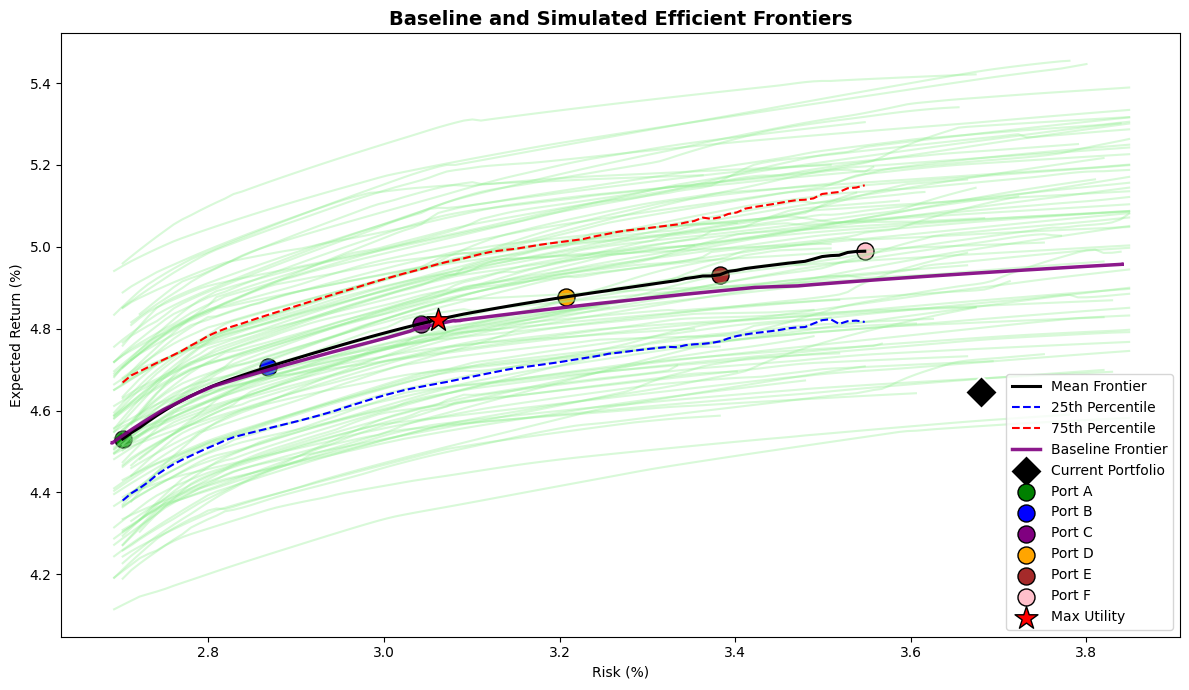

In [17]:
# === Load inputs ===
assets, ratings, mu, sigma_ref, duration, Sigma, company_allocations = load_inputs(EXCEL_PATH, SHEET_NAME)
liability_profiles = load_liability_profiles(LIABILITY_BOOK_PATH)
company_liability_duration = float(liability_profiles.loc["Brighthouse", 'Avg_Duration_yrs'])

# KRD targets & asset bucket matrix (coarse)
krd_targets = liability_bucket_targets(LIABILITY_BOOK_PATH, "Brighthouse") if USE_KRD_MATCH else None
B, krd_names = asset_bucket_matrix_by_duration(duration, KEY_BUCKETS) if USE_KRD_MATCH else (None, None)

# === Simulate frontiers with SURPLUS objective ===
all_frontiers = simulate_efficient_frontiers(
    assets, ratings, mu, Sigma, duration, company_liability_duration,
    n_scenarios=100, n_points=80,  # modest, fast
    krd_targets=krd_targets, B=B, krd_names=krd_names
)

# === Common vol grid ===
vol_min, vol_max = find_common_volatility_range(all_frontiers, trim_pct=0.10)
vol_grid = np.linspace(vol_min, vol_max, 120)

# === Interpolate onto common grid ===
returns_matrix = interpolate_frontiers(all_frontiers, vol_grid)

# === Aggregate only where coverage is adequate (e.g., 80% of scenarios) ===
vg, mean_ret, q25, q75, mask, coverage = aggregate_frontiers(
    returns_matrix, vol_grid, min_coverage_frac=0.80, smooth=True
)

# Build mean weights across scenarios
n_scen, n_assets = len(all_frontiers), len(all_frontiers[0]["weights"][0])
mean_wts_grid = np.full((len(vg), n_assets), np.nan)

for j, v_target in enumerate(vg):
    w_list = []
    for scen in all_frontiers:
        v = np.asarray(scen["vols"])
        wts = np.asarray(scen["weights"])
        if v.size < 3: 
            continue
        # Find closest volatility in that scenario
        idx = np.argmin(np.abs(v - v_target))
        if idx < wts.shape[0]:
            w_list.append(wts[idx])
    if len(w_list) > 0:
        mean_wts_grid[j] = np.nanmean(np.vstack(w_list), axis=0)

# Keep only rows that have finite mean weights
mask_valid = np.isfinite(mean_wts_grid).all(axis=1)
vg_valid, mean_ret_valid, mean_wts_valid = vg[mask_valid], mean_ret[mask_valid], mean_wts_grid[mask_valid]

# === Select representative portfolios (Ports A–F + Max Utility) ===
from copy import deepcopy

# Evenly spaced vols across the mean frontier
target_vols = np.linspace(vg_valid.min(), vg_valid.max(), 6)
sel_idx = [np.argmin(np.abs(vg_valid - tv)) for tv in target_vols]

# Max-utility point on mean frontier (same utility definition)
SURPLUS_LAMBDA = 8.0  # or your global value
max_util_idx = np.argmax(mean_ret_valid - SURPLUS_LAMBDA * (vg_valid**2))

portfolio_indices = sel_idx + [max_util_idx]
portfolio_names = ["Port A", "Port B", "Port C", "Port D", "Port E", "Port F", "Max Utility"]

# Gather results
def pack_row_mean(w):
    ret = float(mu @ w)
    vol = float(np.sqrt(w @ Sigma @ w))
    fi_dur = float(duration @ w)
    cap_use = float(cap_charge @ w)
    net_dur = fi_dur - company_liability_duration

    # --- Compute average FI credit rating (same as baseline) ---
    has_rating = np.array([s is not None for s in rating_scores])
    if has_rating.any():
        ww = w[has_rating]
        ss = np.array([s for s in rating_scores if s is not None])
        tot = ww.sum()
        if tot > 1e-6:
            score = (ww @ ss) / tot
            back = {1:"AAA",2:"AA+",3:"AA",4:"AA-",5:"A+",6:"A",7:"A-",
                    8:"BBB+",9:"BBB",10:"BBB-",11:"BB+",12:"BB",13:"BB-",
                    14:"B+",15:"B",16:"B-",17:"CCC"}
            avg_rating = back.get(int(round(score)), f"~{score:.1f}")
        else:
            avg_rating = None
    else:
        avg_rating = None

    return {
        'Expected Return (%)': 100*ret,
        'Risk (%)': 100*vol,
        'Sharpe Ratio': (ret - RISK_FREE)/vol if vol > 1e-9 else 0.0,
        'Avg FI Credit Rating': avg_rating,
        'FI Duration (years)': fi_dur,
        'Net Duration (years)': net_dur,
        'Capital Use (%)': 100*cap_use
    }

# === Add Current portfolio first ===
rating_scores = np.array([rating_to_numeric_fixed(r) for r in ratings])
_df_raw = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME).dropna(how="all")
cap_charge = _df_raw.iloc[:, 3].astype(float).values
current_alloc = company_allocations['Brighthouse']
current_ret = float(mu @ current_alloc)
current_vol = float(np.sqrt(current_alloc @ Sigma @ current_alloc))
current_net_dur = float(duration @ current_alloc) - company_liability_duration

# Compute Avg FI Credit Rating for current portfolio (same logic)
has_rating = np.array([s is not None for s in rating_scores])
if has_rating.any():
    ww = current_alloc[has_rating]
    ss = np.array([s for s in rating_scores if s is not None])
    tot = ww.sum()
    if tot > 1e-6:
        score = (ww @ ss) / tot
        back = {1:"AAA",2:"AA+",3:"AA",4:"AA-",5:"A+",6:"A",7:"A-",
                8:"BBB+",9:"BBB",10:"BBB-",11:"BB+",12:"BB",13:"BB-",
                14:"B+",15:"B",16:"B-",17:"CCC"}
        avg_rating_current = back.get(int(round(score)), f"~{score:.1f}")
    else:
        avg_rating_current = None
else:
    avg_rating_current = None

results_mean = {}

results_mean["Current"] = {
    'Expected Return (%)': 100*current_ret,
    'Risk (%)': 100*current_vol,
    'Sharpe Ratio': (current_ret - RISK_FREE)/current_vol if current_vol > 1e-9 else 0.0,
    'Avg FI Credit Rating': avg_rating_current,
    'FI Duration (years)': float(duration @ current_alloc),
    'Net Duration (years)': current_net_dur,
    'Capital Use (%)': 100*float(cap_charge @ current_alloc)
}
for a, wt in zip(assets, current_alloc):
    results_mean["Current"][a] = 100*wt

for name, i in zip(portfolio_names, portfolio_indices):
    w = mean_wts_valid[i]
    results_mean[name] = pack_row_mean(w)
    for a, wt in zip(assets, w):
        results_mean[name][a] = 100*wt

df_mean = pd.DataFrame(results_mean)
# === Format the MEAN FRONTIER portfolio table (same as baseline style) ===
summary_metrics = [
    'Expected Return (%)',
    'Risk (%)',
    'Sharpe Ratio',
    'Avg FI Credit Rating',
    'FI Duration (years)',
    'Net Duration (years)',
    'Capital Use (%)'
]

# Convert metrics to strings (2 decimals)
df_disp = df_mean.copy()
for metric in summary_metrics:
    df_disp.loc[metric] = df_disp.loc[metric].apply(
        lambda x: f"{float(x):.2f}" if not isinstance(x, str) else x
    )

# Identify asset rows (everything else)
asset_rows = [r for r in df_disp.index if r not in summary_metrics]

# One decimal for weights
for r in asset_rows:
    df_disp.loc[r] = df_disp.loc[r].apply(lambda x: f"{float(x):.1f}")

# === Style and display (blue gradient across all assets) ===
styled_mean = (
    df_disp.loc[summary_metrics + asset_rows]
    .style.background_gradient(
        cmap='Blues', axis=None,
        subset=pd.IndexSlice[asset_rows, :],
        vmin=0, vmax=15
    )
)

display(styled_mean)

# Optional: see coverage profile
# print("Coverage at kept grid points (min..max):", coverage[mask].min(), coverage[mask].max())

# === Baseline frontier already computed as 'baseline_pts' (decimals) ===

# === Baseline frontier (SURPLUS) using *central* mu,Sigma ===
n = len(assets)
wmin, wmax = np.full(n, W_MIN_DEFAULT), np.full(n, W_MAX_DEFAULT)
rating_scores = np.array([rating_to_numeric_fixed(r) for r in ratings])

# Read capital charges once
_df_raw = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME).dropna(how="all")
cap_charge = _df_raw.iloc[:, 3].astype(float).values

lambdas = np.geomspace(1.0, 50.0, 60)
baseline_pts = []
for lam in lambdas:
    sol = solve_surplus_qp(mu, Sigma, duration, cap_charge, wmin, wmax,
                           assets, ratings, rating_scores, company_liability_duration,
                           krd_targets=krd_targets, B=B, krd_names=krd_names, krd_tol=KRD_TOL,
                           surplus_lambda=lam, cap_penalty_phi=CAP_PENALTY_PHI)
    if sol:
        w_opt, var, ret = sol
        baseline_pts.append((ret, np.sqrt(var)))

# Current portfolio point (decimals)
current_alloc = company_allocations['Brighthouse']
ret_c = float(mu @ current_alloc)
vol_c = float(np.sqrt(current_alloc @ Sigma @ current_alloc))
current_pt = (ret_c, vol_c)

# === Plot ===
# === Plot resampled frontiers with mean-portfolios overlay ===
plt.figure(figsize=(12,7))

# Individual simulated frontiers
for i in range(returns_matrix.shape[0]):
    plt.plot(100*vol_grid, 100*returns_matrix[i, :], color='lightgreen', alpha=0.35)

# Aggregated mean and IQR
plt.plot(100*vg, 100*mean_ret, color='black', linewidth=2.2, label="Mean Frontier")
plt.plot(100*vg, 100*q25, linestyle='--', color='blue',  label="25th Percentile")
plt.plot(100*vg, 100*q75, linestyle='--', color='red',   label="75th Percentile")

# Baseline
if baseline_pts:
    rets, sigmas = zip(*baseline_pts)
    plt.plot([100*s for s in sigmas], [100*r for r in rets],
             color='purple', alpha=0.9, linewidth=2.5, label="Baseline Frontier")

# Current
plt.scatter([100*current_pt[1]], [100*current_pt[0]], s=280, c='black', marker='D',
            edgecolors='white', linewidth=1.5, label="Current Portfolio", zorder=5)

# === Mean frontier representative portfolios ===
colors = ['green','blue','purple','orange','brown','pink']
for name, i, color in zip(portfolio_names[:-1], sel_idx, colors):
    plt.scatter(100*vg_valid[i], 100*mean_ret_valid[i], s=150, c=color, marker='o',
                edgecolors='black', label=name)
plt.scatter(100*vg_valid[max_util_idx], 100*mean_ret_valid[max_util_idx],
            s=300, c='red', marker='*', edgecolors='black', label='Max Utility', zorder=5)

plt.xlabel("Risk (%)")
plt.ylabel("Expected Return (%)")
plt.title("Baseline and Simulated Efficient Frontiers", fontsize=14, fontweight='bold')
plt.legend(loc='best'); plt.grid(True, alpha=0); plt.tight_layout(); plt.show()